# Contents
#### 1. Importing libraries
#### 2. Importing data
#### 3. Subsetting, wrangling, and cleaning
#### 4. Time-series analysis: Decomposition
#### 5. Testing for stationarity
#### 6. Stationarizing the data
#### 7. Defining parameters
#### 8. Splitting the data
#### 9. Running and fitting the model

# 1. Importing libraries

In [4]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

# 2. Importing data

In [5]:
# Configure API key 
quandl.ApiConfig.api_key = '2e__A3mEHHKQPKs1GzAV'

In [6]:
data = quandl.get('FRED/GDPC1')

In [7]:
data.head(5)

,Value
Date,
1947-01-01,2034.450
1947-04-01,2029.024
1947-07-01,2024.834
1947-10-01,2056.508
1948-01-01,2087.442


In [8]:
data.shape

(300, 1)

In [9]:
data.columns

Index(['Value'], dtype='object')

In [10]:
type(data)

pandas.core.frame.DataFrame

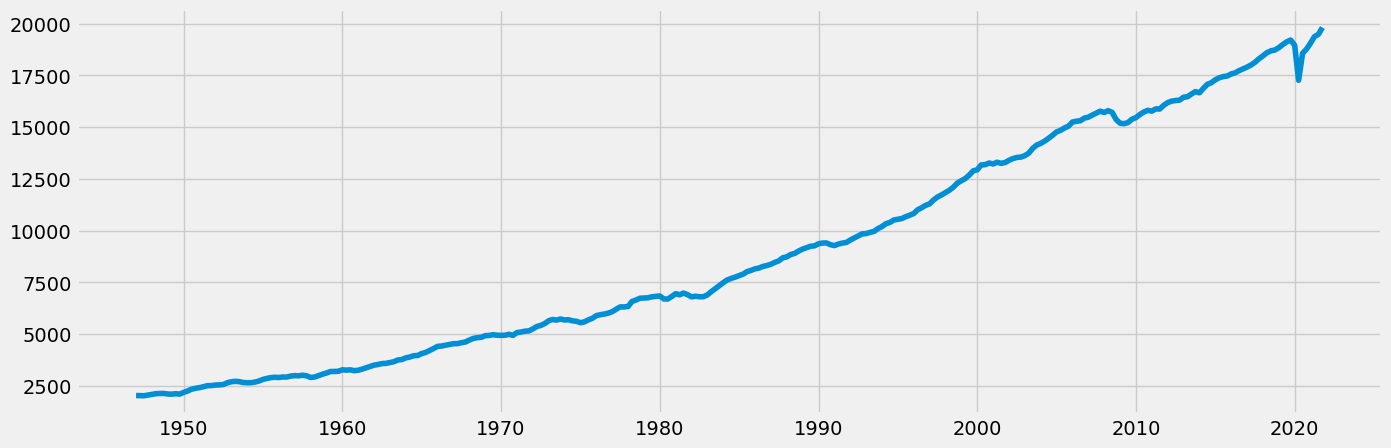

In [11]:
# Plot the data 
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

# 3. Subsetting, wrangling and cleaning

In [13]:
# Reset index to use date column as a filter
data_2 = data.reset_index()

In [14]:
data_2.head()

,Date,Value
0,1947-01-01,2034.450
1,1947-04-01,2029.024
2,1947-07-01,2024.834
3,1947-10-01,2056.508
4,1948-01-01,2087.442


In [15]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2024-08-01')]

I chose a subset of 1980 to 2024 in order to exclude the time before 1980 where econoomic conditions were very different from today.

In [17]:
data_sub.shape

(168, 2)

In [18]:
data_sub.head()

,Date,Value
132,1980-01-01,6842.024
133,1980-04-01,6701.046
134,1980-07-01,6693.082
135,1980-10-01,6817.903
136,1981-01-01,6951.495


In [19]:
# Set date column as the index again

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
1980-01-01,6842.024
1980-04-01,6701.046
1980-07-01,6693.082
1980-10-01,6817.903
1981-01-01,6951.495


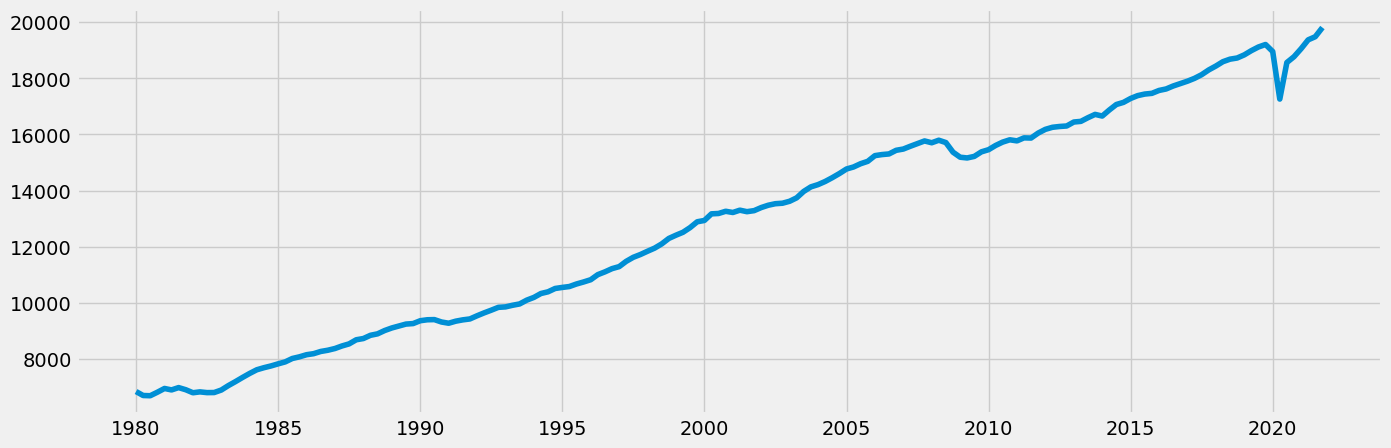

In [20]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [21]:
# Check for missing values 
data_sub.isnull().sum() 

Value    0
dtype: int64

In [22]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

# 4. Time-series analysis: Decomposition

In [24]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [25]:
# Define a fixed size for all special charts
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

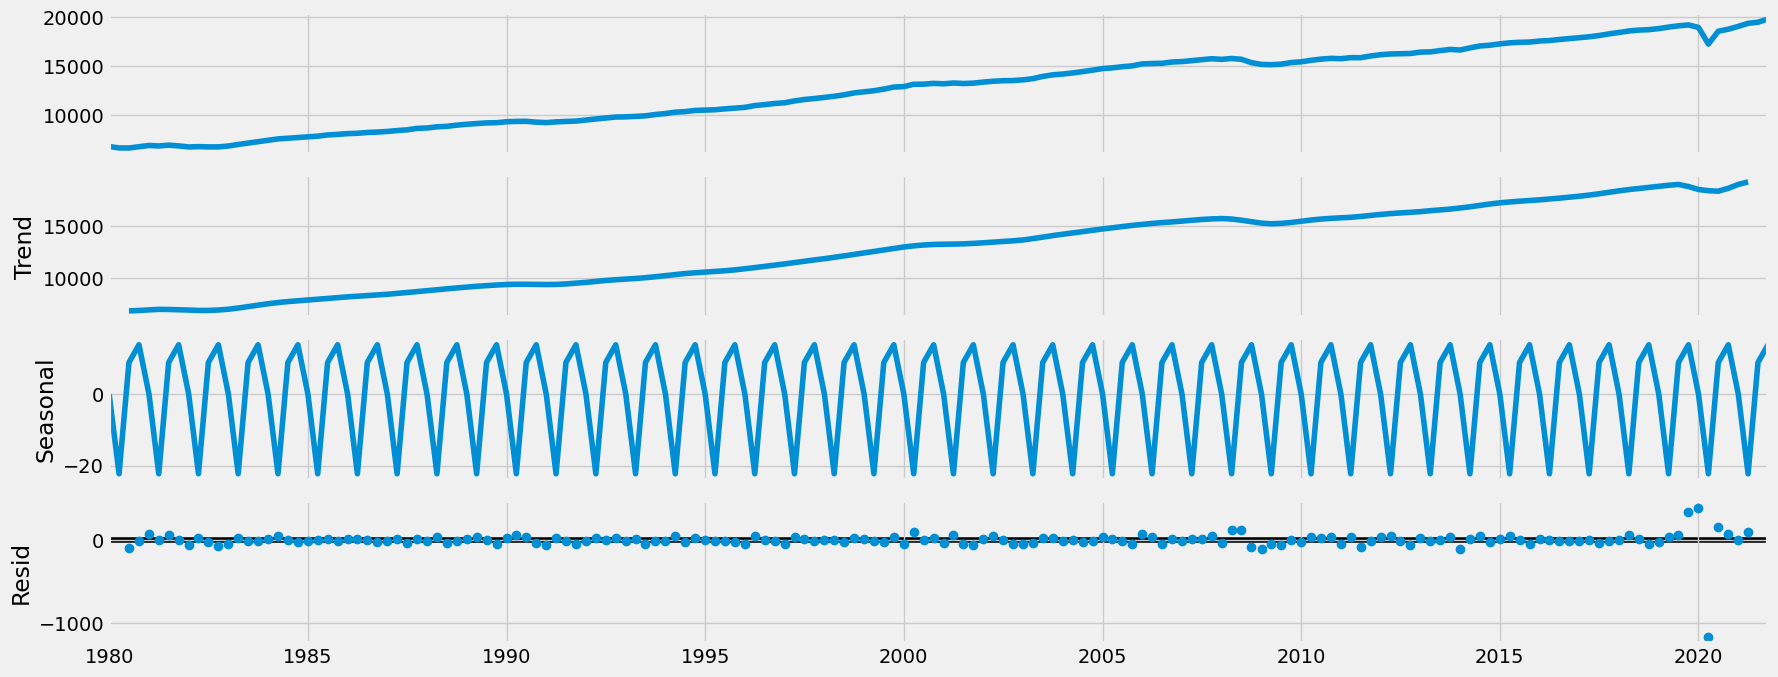

In [26]:
# Plot the components
decomposition.plot()
plt.show()

Interpretation: 
As the data doesn't have much noise, the trend line looks very similar to the level line and shows a dominant upward trend over the years. There are a few bumps in the trend, f.e. around 2007/2008 (global financial crisis) and 2020 (Covid-pandemic). 
As one can see in the third graph, there are seasonal fluctuations in the data, showing a regular pattern. 
As can be seen in the residual graph, there isn't much unexplained noise in the data, apart from some noise around 2007/2008 and 2019-2021. As mentioned before, these deviations stem from the global financial crisis and the Covid pandemic.

# 5. Testing for stationarity

In [29]:
# As the adfuller() function will import from the model from statsmodels for the test and will only return 
# an array of numbers, I also need to define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.357416
p-value                          0.979831
Number of Lags Used              1.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64


Interpretation: The p-value shows that the test is not significant. As the critical value (5%) is smaller than the test statistic, this means that we cannot reject the null hypothesis. As the null hypothesis is that there's a unit root and the data is stationary and because we cannot rule out the null hypothesis, this means that the data is non-stationary and we have to conduct a stationarization.

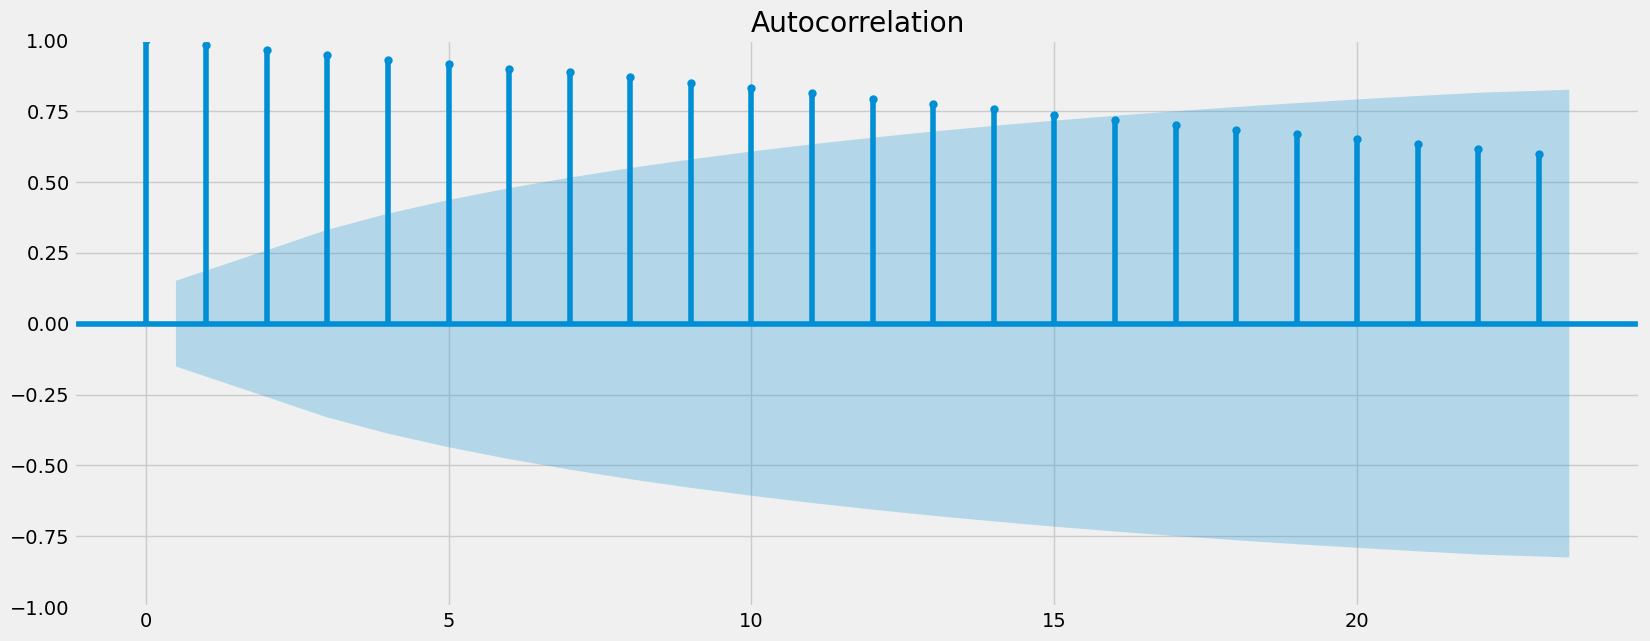

In [31]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_sub)
plt.show()

# 6. Stationarizing the data

In [33]:
# Stationarizing using differencing
data_diff = data_sub - data_sub.shift(1) 

In [34]:
# Remove the missing values that came about as a result of the differencing. 
data_diff.dropna(inplace = True) 

In [35]:
data_diff.head()

,Value
datetime,
1980-04-01,-140.978
1980-07-01,-7.964
1980-10-01,124.821
1981-01-01,133.592
1981-04-01,-51.515


In [36]:
data_diff.columns

Index(['Value'], dtype='object')

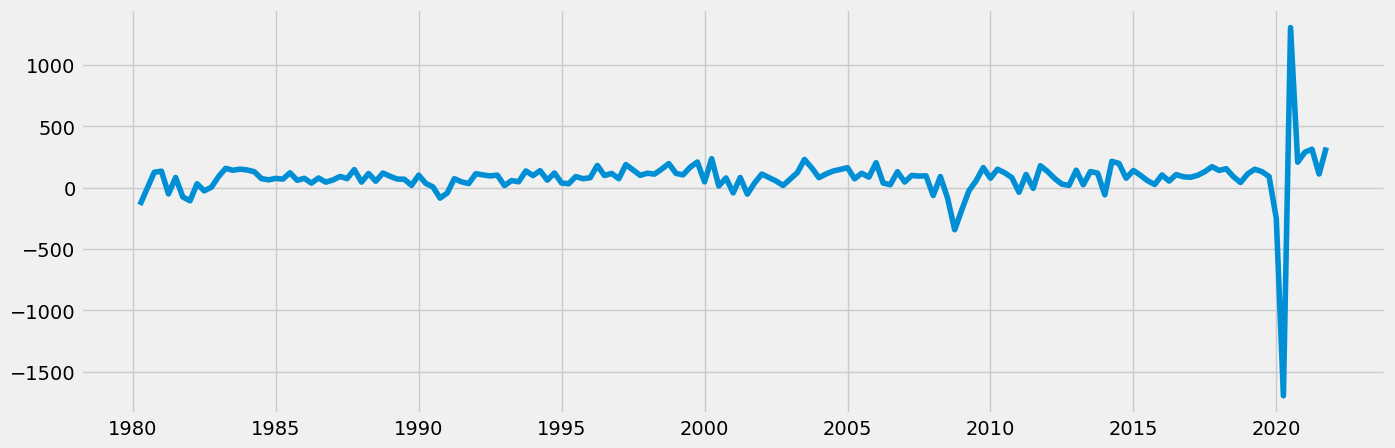

In [37]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [38]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.517608e+01
p-value                        6.292029e-28
Number of Lags Used            0.000000e+00
Number of Observations Used    1.660000e+02
Critical Value (1%)           -3.470370e+00
Critical Value (5%)           -2.879114e+00
Critical Value (10%)          -2.576139e+00
dtype: float64


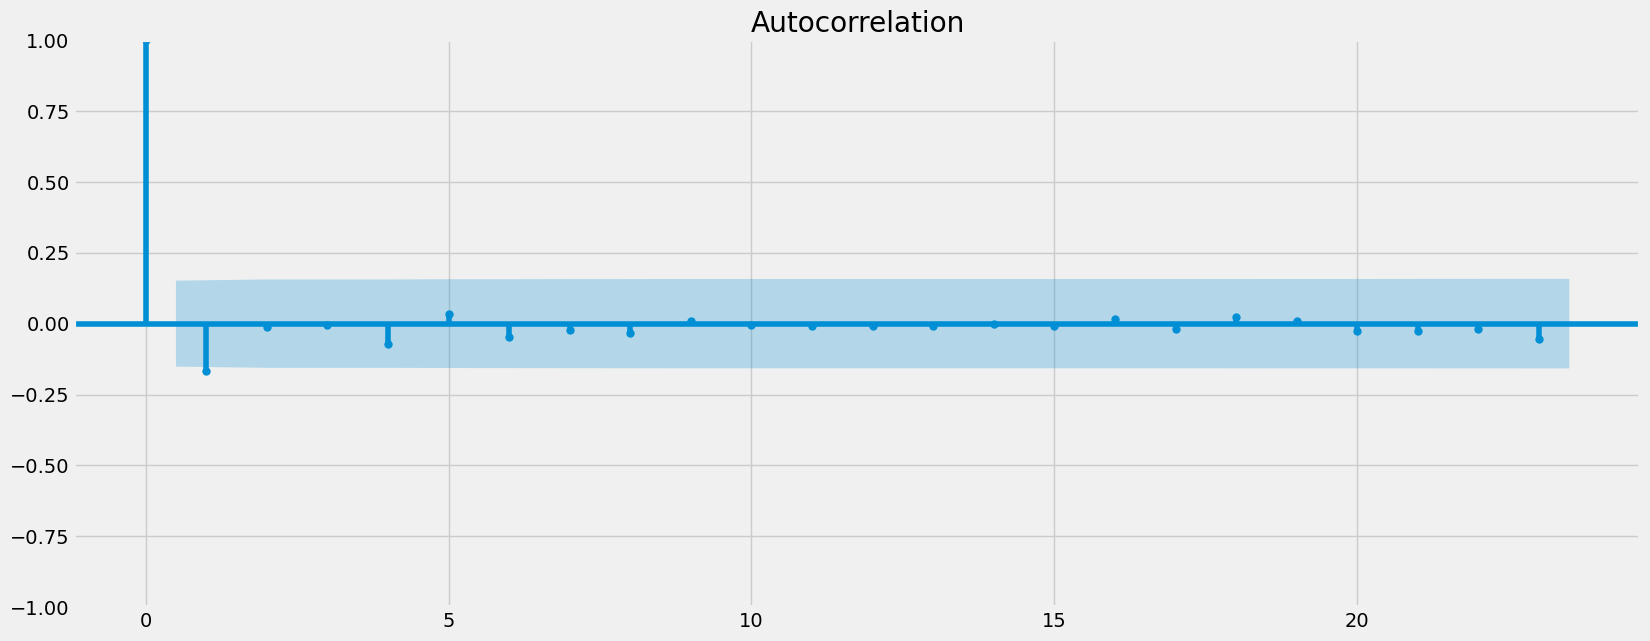

In [39]:
plot_acf(data_diff)
plt.show()

# 7. Defining parameters

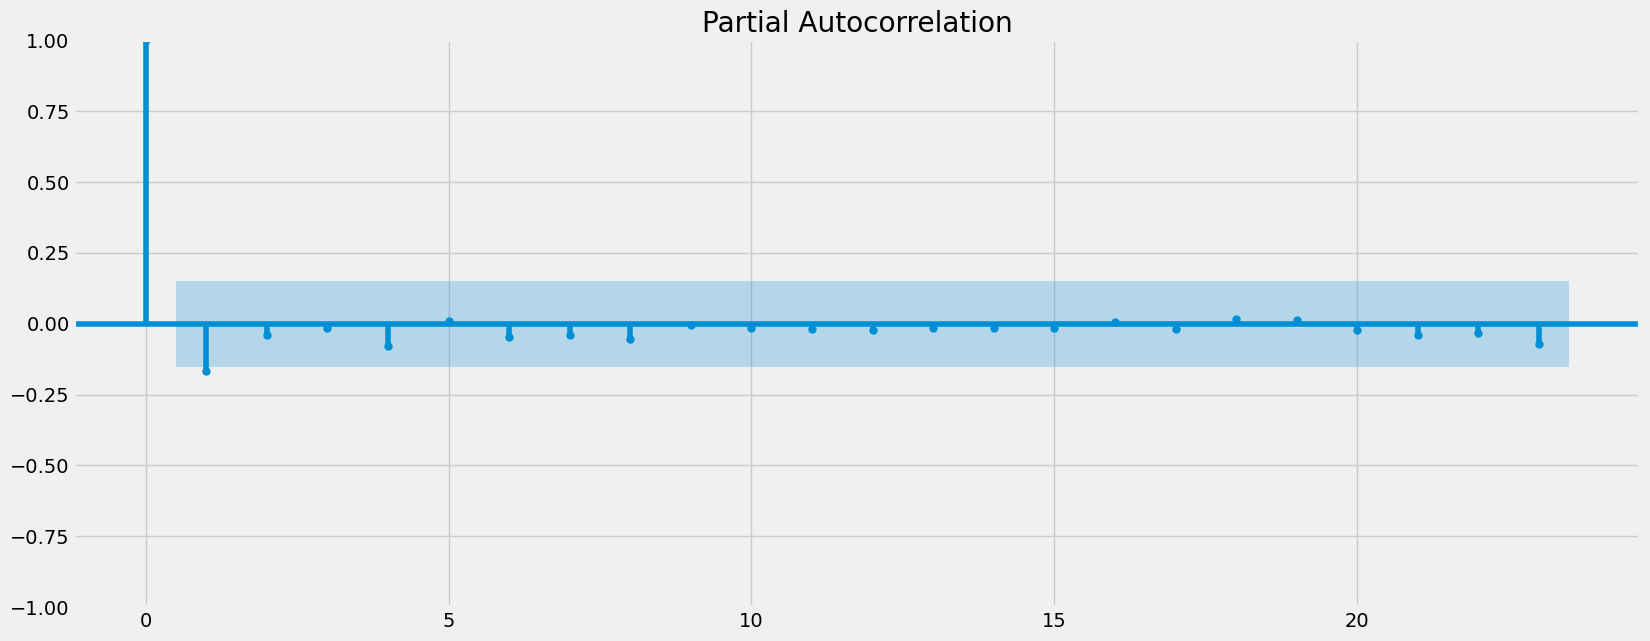

<Figure size 4500x4500 with 0 Axes>

In [42]:
# Plot partial autocorrelations to determine parameter p
plot_pacf(data_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

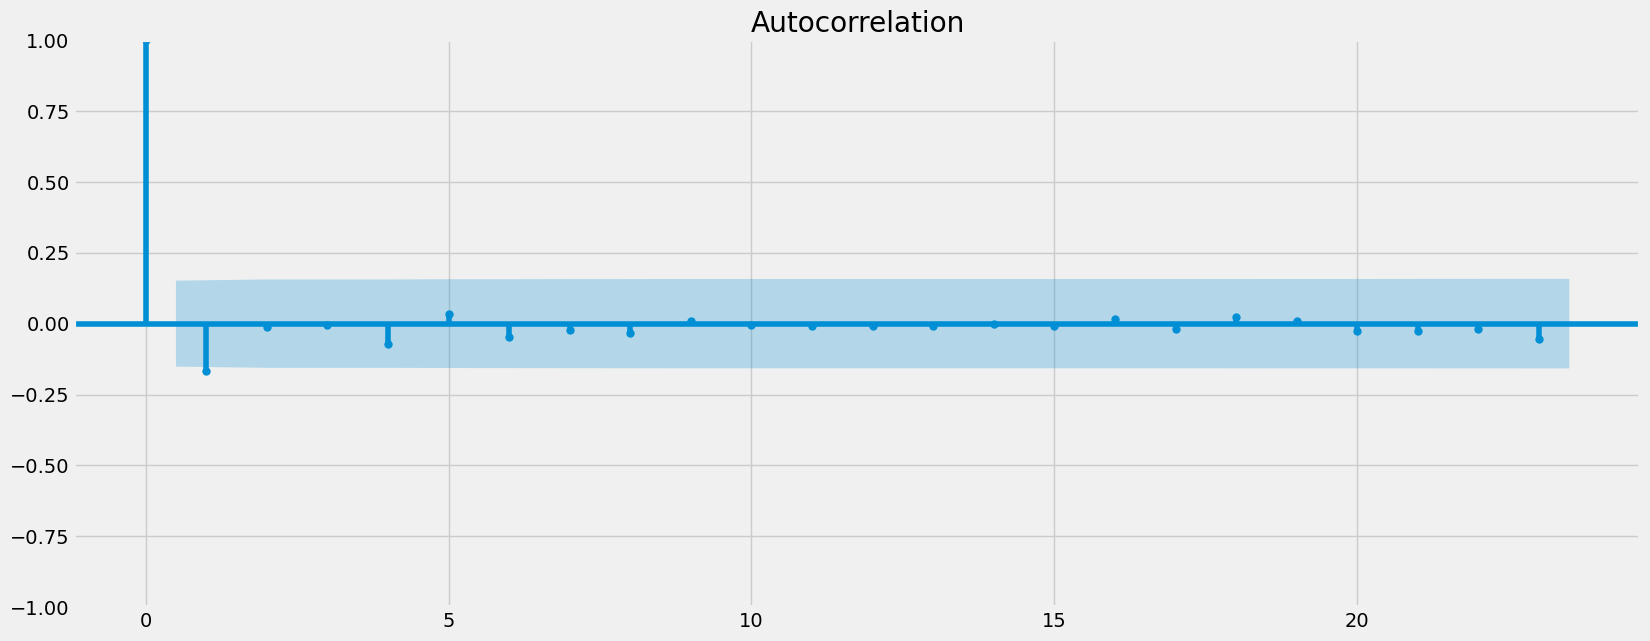

<Figure size 1500x500 with 0 Axes>

In [43]:
# Plot autocorrelations to determine parameter q
plot_acf(data_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

# 8. Splitting the data

In [45]:
# Split the data
train = data_diff['Value'][:161]
test = data_diff['Value'][160:]

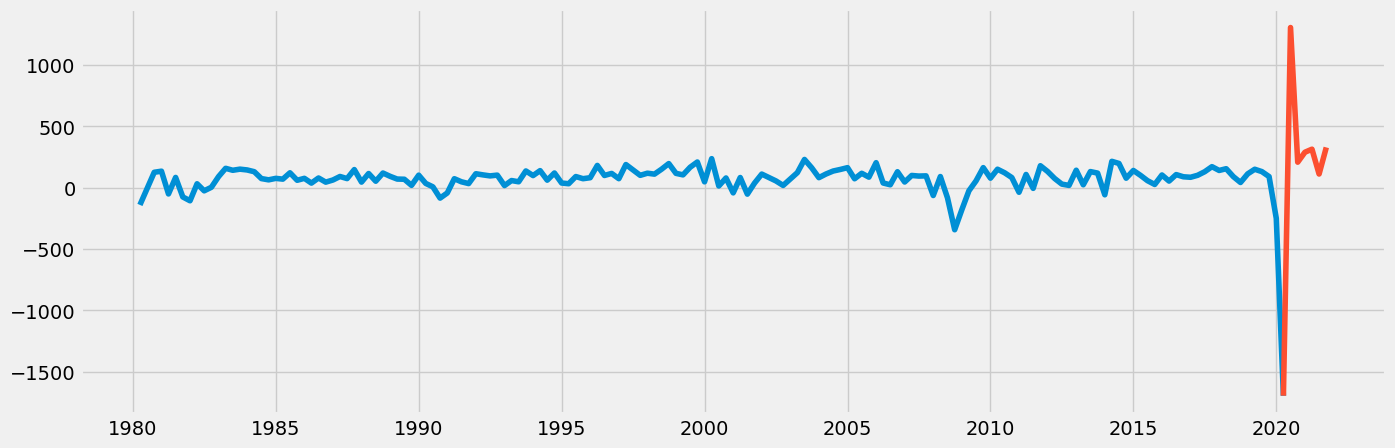

In [46]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [47]:
test.shape

(7,)

# 9. Running and fitting the model

In [49]:
from statsmodels.tsa.api import ARIMA

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  161
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1022.526
Date:                Thu, 12 Sep 2024   AIC                           2051.051
Time:                        09:28:09   BIC                           2060.277
Sample:                    04-01-1980   HQIC                          2054.797
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4921      2.640      0.186      0.852      -4.681       5.665
ma.L1         -0.4228      2.627     -0.161      0.872      -5.572       4.726
sigma2      2.089e+04   1647.304     12.680      0.0

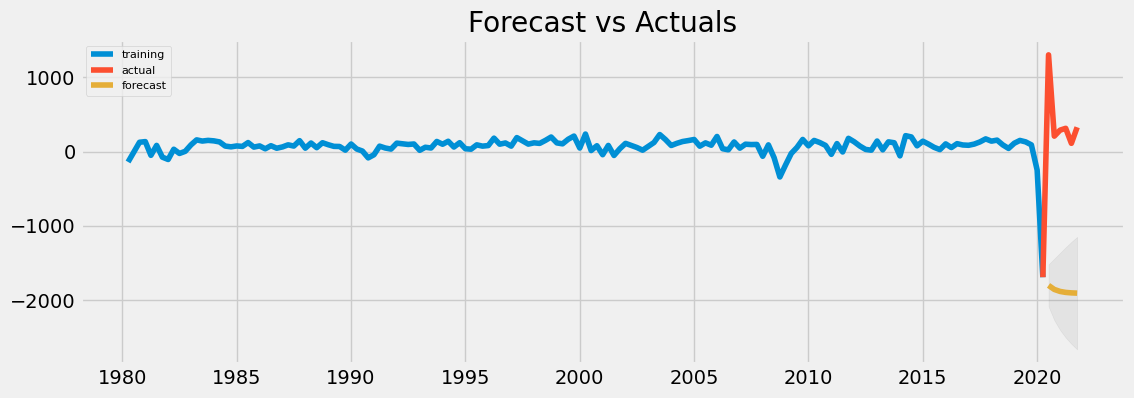

In [99]:
# Fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  
print(fitted.summary()) 

# Forecast
fc = fitted.forecast(7)  # Get forecasted values
conf = fitted.get_forecast(7).conf_int()  # Get confidence intervals 

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) 
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

This does not represent a good forecast as the forecasted and actual values are far away from each other. More iterations are needed to develop a suitable forecasting model.